In [100]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import distance

In [101]:
class node:
    def __init__(self, x, y, xPre, yPre, dist=0, indPre=0):
        self.x = [x]
        self.y = [y]
        self.xPre = [xPre]
        self.yPre = [yPre]
        self.dist = [dist]
        self.indPre = [indPre]
        
class path:
    def __init__(self, x, y):
        self.x = [x]
        self.y = [y]

In [102]:
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)

def DrawStaticObstacle(pose, radius):
    N_obs = len(pose[0])   
    for i in range(N_obs):
        curObs = [pose[0][i], pose[1][i]]
        NOP = 100000
        THETA = np.linspace(0, 2*math.pi, NOP, endpoint=True)
        RHO = [radius]*NOP
        [X, Y] = pol2cart(RHO, THETA)
        X = X + curObs[0]
        Y = Y + curObs[1]
        plt.plot(X, Y, 'k.', markersize=1)

In [103]:
def sqrt_mse(front, back):
    return math.sqrt(2*((math.pow(front[0]-back[0], 2)) + math.pow(front[1]-back[1], 2)))

def axis_check(axis, center, radius):
    dist = sqrt_mse(center, axis)
    if dist <= radius:
        return 1
    else: 
        return 0

def line_check(axis1, axis2, center, radius):
    add = 30
    radius += add
    gradient = (axis2[1] - axis1[1]) / (axis2[0] - axis1[0])
    value = axis1[1] - (gradient*axis1[0]) 
    a = math.pow(gradient, 2) + 1
    b = 2 * gradient * value
    c = math.pow(value, 2) - math.pow(radius, 2)
    D = math.pow(b, 2) - 4*a*c
    if D >= 0:
        return 1
    else:
        return 0

def colCheckLinesegCirc(point1, point2, center, radius):
    dist1 = sqrt_mse(point1, center)
    dist2 = sqrt_mse(point2, center)
    relativePose = [point2[0] - point1[0], point2[1] - point1[1]]
    relativeDist = sqrt_mse(point2, point1)

    if dist1 <= radius or dist2 <= radius:
        return 1
    else:
        if relativeDist < 0.0001:
            abs_rpoj_v = ((center[0] - point1[0]) * relativePose[0] + (center[1] - point1[1]) * relativePose[1]) / 0.001
        else:
            abs_proj_v = ((center[0] - point1[0]) * relativePose[0] + (center[1] - point1[1]) * relativePose[1]) / relativeDist
        
        if abs_proj_v < 0:
            closest = point1
            return 0
        elif abs_proj_v > sqrt_mse(point2, point1):
            closest = point2
            return 0
        else:
            if sqrt_mse(point2, point1) < 0.0001:
                proj_v = [abs_proj_v * relativePose[0] / 0.001, abs_proj_v * relativePose[1] / 0.001]
            else:
                 proj_v = [abs_proj_v * relativePose[0] / sqrt_mse(point2, point1), abs_proj_v * relativePose[1] / sqrt_mse(point2, point1)]
            closest = point1 + proj_v
            distCenter = sqrt_mse(center, closest)
            if distCenter <= radius:
                return 1
            else:
                return 0

In [104]:
def PathRefine(robot, goal, Obs, path, r):
    pathLength = len(path.x)
    vector_x_pos = []
    vector_y_pos = []
    
    for i in range(pathLength):
        vector_x_pos.append(path.x[i])
        vector_y_pos.append(path.y[i])
    
    finalPath_refine = [vector_x_pos, vector_y_pos]
    distTable =  [[0]*pathLength]*pathLength
    
    for i in range(pathLength):
        for j in range(pathLength):
            A = math.pow(finalPath_refine[0][i] - finalPath_refine[0][j], 2)
            B = math.pow(finalPath_refine[1][i] - finalPath_refine[1][j], 2)
            MSE = (A + B) / 2
            distTable[i][j] = math.sqrt(2 * MSE) 
    
    N_obs = len(Obs[0]) + 1
    extendedObs = [[Obs[0][0], Obs[0][1], 0], [Obs[1][0], Obs[1][1], 0]]
    startTag = pathLength - 1
    testTag = pathLength - 2
    refinePathTags = []
    refinePathTags.append(startTag)
    
    for i in range(50):
        if distTable[startTag][testTag-1] < (distTable[startTag][testTag] + distTable[testTag][testTag-1]):
            startTagPos = [finalPath_refine[0][startTag], finalPath_refine[1][startTag]]
            testTagPos = [finalPath_refine[0][testTag-1], finalPath_refine[1][testTag-1]]
            colTag = 0
            localColTag = []
            lineCheck1 = line_check(startTagPos, testTagPos, center1, r)
            lineCheck2 = line_check(startTagPos, testTagPos, center2, r)
            if lineCheck1 == 1 or lineCheck2 == 1:
                colTag = 1
            
            if colTag == 0:    
                for m in range(N_obs):
                    curObs = [extendedObs[0][m], extendedObs[1][m]]
                    localColTag.append(colCheckLinesegCirc(startTagPos, testTagPos, curObs, r))
                    if localColTag[-1] == 1:
                        colTag = 1
                        break

            if colTag == 1:
                refinePathTags.insert(0, testTag)
                startTag = testTag
                testTag = testTag - 1
            else:
                testTag = testTag - 1
            
            if testTag == 0:
                break
                
    refinePathTags.insert(0, 1)
    range_Num = len(refinePathTags)
    for j in range(range_Num-1):
        ax.plot([finalPath_refine[0][refinePathTags[j]], finalPath_refine[0][refinePathTags[j+1]]], [finalPath_refine[1][refinePathTags[j]], finalPath_refine[1][refinePathTags[j+1]]], 'k--', linewidth=3)
        ax.plot(finalPath_refine[0][j], finalPath_refine[1][j], 'ko', markersize=10, linewidth=2)  
    
    F_X = []
    F_Y = []
    for i in range(range_Num):
        F_X.append(finalPath_refine[0][refinePathTags[i]])
        F_Y.append(finalPath_refine[1][refinePathTags[i]])
    
    return [F_X, F_Y]

In [105]:
def RRT(node, path, start, end):
    for i in range(1, 3001):
        x_rand = [start[0] + (end[0]-start[0])* np.random.rand(1), start[1] + (end[1]-start[1])* np.random.rand(1)]
        RandCheck1 = axis_check(x_rand, center1, r)
        RandCheck2 = axis_check(x_rand, center2, r)
        
        if RandCheck1 == 1 or RandCheck2 == 1:
            continue
            
        min_dist = 9999999
        near_iter = 0
        N = len(node.x)
   
        for j in range(N):
            x_near = [node.x[j], node.y[j]]
            dist = distance.euclidean(x_rand, x_near)
            if min_dist > dist:
                min_dist = dist
                near_iter = j
            
        x_near = [node.x[near_iter], node.y[near_iter]]
        near_rand = [x_rand[0]-x_near[0], x_rand[1]-x_near[1]]
        normlized = [near_rand[0] / distance.euclidean(x_rand, x_near)*stepsize, near_rand[1] / distance.euclidean(x_rand, x_near)*stepsize]
        x_new = [x_near[0] + normlized[0], x_near[1] + normlized[1]] 
        
        NewCheck1 = axis_check(x_new, center1, r)
        NewCheck2 = axis_check(x_new, center2, r)
        
        if NewCheck1 == 1 or NewCheck2 == 1:
            continue
            
        CollisionCheck1 = colCheckLinesegCirc(x_new, x_rand, center1, r)
        CollisionCheck2 = colCheckLinesegCirc(x_new, x_rand, center2, r)

        if CollisionCheck1 == 1 or CollisionCheck2 == 1:
            continue

        ax.plot([x_near[0], x_new[0]], [x_near[1], x_new[1]], 'b-')
        node.x.append(x_new[0])
        node.y.append(x_new[1])
        node.xPre.append(x_near[0])
        node.yPre.append(x_near[1])
        node.dist.append(distance.euclidean(x_new, x_near))
        node.indPre.append(near_iter)

        if distance.euclidean(x_new, end) < 40:
            break 

    if True:
        path.x[0] = end[0]
        path.y[0] = end[1]
        path.x.append(node.x[-1])
        path.y.append(node.y[-1])
        path_index = node.indPre[-1]

        while True:
            path.x.append(node.x[path_index])
            path.y.append(node.y[path_index])
            path_index = node.indPre[path_index]
            if path_index == 0:
                break

        path.x.append(start[0])
        path.y.append(start[1])
        Range_Num = len(path.x)
        for j in range(1, Range_Num):
            ax.plot([path.x[j], path.x[j-1]], [path.y[j], path.y[j-1]], 'r:', linewidth=3)

        ax.plot([start[0], path.x[-3]],[start[1], path.y[-3]], 'r:', linewidth=3)
    else:
        print('no path to end')

In [106]:
stepsize = 30

robot = [1, 1]
robot_wd = 20
safe_distance = 50
a = 0 
b = 800
Obs = [[300, 450],[300, 700]]
center1 = [300, 300]
center2 = [450, 700]
obs_o = 130
goal = [500, 900]
waypoint_1 = [450, 500]
waypoint_2 = [700, 700]

In [107]:
v = node(robot[0], robot[1], robot[0], robot[1])
v2 = node(waypoint_1[0], waypoint_1[1], waypoint_1[0], waypoint_1[1])
v3 = node(waypoint_2[0], waypoint_2[1], waypoint_2[0], waypoint_2[1])
pos = path(0, 0)
pos2 = path(0, 0)
pos3 = path(0, 0)

C:\Users\tjdgu\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\tjdgu\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
C:\Users\tjdgu\anaconda3\envs\tf\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of list

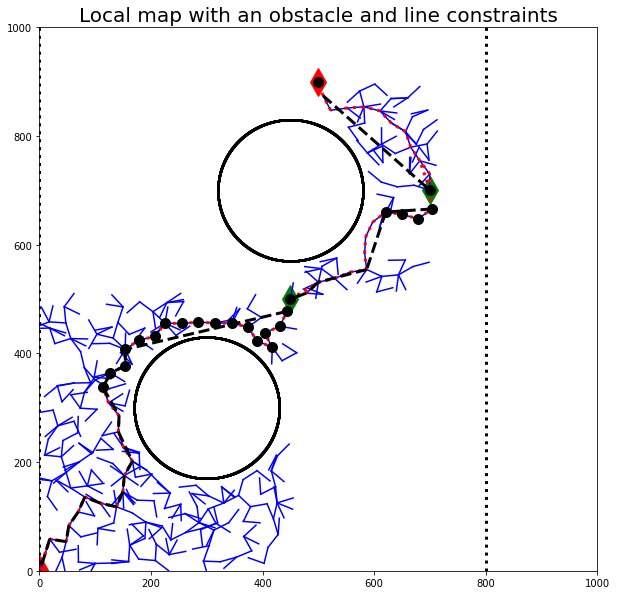

In [108]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Local map with an obstacle and line constraints', fontsize=20)
# waypoint 구현
plt.xlim(0, 1000)
plt.ylim(0, 1000)
ax.plot(robot[0], robot[1], 'rd', markersize = 20, linewidth=7)
ax.axvline(x=0, c='k', linestyle=':', linewidth=3)
ax.axvline(x=800, c='k', linestyle=':', linewidth=3)
ax.plot(waypoint_1[0], waypoint_1[1], 'gd', markersize = 20, linewidth=5)
ax.plot(waypoint_2[0], waypoint_2[1], 'gd', markersize = 20, linewidth=5)
ax.plot(goal[0], goal[1], 'rd', markersize = 20, linewidth=7)
DrawStaticObstacle(Obs, obs_o) # static obstacle

r = robot_wd + obs_o + safe_distance

RRT(v, pos, robot, waypoint_1)
RRT(v2, pos2, waypoint_1, waypoint_2)
RRT(v3, pos3, waypoint_2, goal)

Final_1 = PathRefine(robot, waypoint_1, Obs, pos, r)
Final_2 = PathRefine(waypoint_1, waypoint_2, Obs, pos2, r)
Final_3 = PathRefine(waypoint_2, goal, Obs, pos3, r)
Add = []
Add.append(Final_3[0] + Final_2[0] + Final_1[0])
Add.append(Final_3[1] + Final_2[1] + Final_1[1])
number = []

rangenum = len(Add[0])-1
for i in range(rangenum):
    if Add[0][i] != Add[0][i+1] and Add[1][i] != Add[1][i+1]:
        number.append(i)

Add_x = []
Add_y = []
for j in number:
    Add_x.append(Add[0][j])
    Add_y.append(Add[1][j])

Final_path = []
Final_path.append(Add_x)
Final_path.append(Add_y)